# Linear Regression with Loss Minimization


In this notebook, we will start looking at **Regression** with Linear Models. Technically, we will:
- Choose a linear model
- Fit the model with some training data
- Evaluate performances.

Let's start importing some useful modules.

In [43]:
#from __future__ import print_function
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

from scipy import optimize, linalg
from pprint import pprint
from jupyterthemes import jtplot

# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
# set "context" (paper, notebook, talk, or poster)
# & font scale (scalar applied to labels, legend, etc.)
jtplot.style('grade3', context='paper', fscale=1.4)
jtplot.style(ticks=True, grid=False)
jtplot.figsize(x=15, y=5)

Let's import our dataset and, to have an idea of the problem, let's print samples

In [44]:
olympics = sio.loadmat('olympics.mat')
data_male = np.genfromtxt('male100.csv',delimiter=',').T
data_female = np.genfromtxt('female100.csv',delimiter=',').T

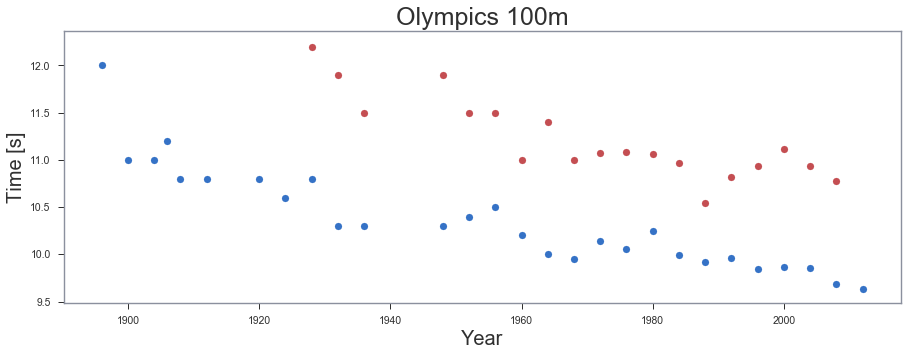

In [45]:
fig = plt.figure(figsize=(15,5))#figsize=(15,10)
ax = fig.add_subplot(111)

ax.scatter(data_male[0], data_male[1], color='b')
ax.scatter(data_female[0], data_female[1], color='r')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m', fontsize=25)

plt.show()

## Simple formulation

For the moment, we generally define the regression function as follows:
$$
t = f(x) = \sum_k^K \omega_kx^k
$$

In [46]:
def regression(x, w):
    return np.polynomial.polynomial.polyval(x, w)

Let's, then, define our loss function as 
$$
L = \dfrac{1}{N}\sum_{i=0}^N\left[ t_i - f(x_i; \mathbf{\omega})\right]^2
$$
It is the squared difference between the true response (winning time), $t_n$ when the input is $x_n$ and the response predicted by the model. $L$ tells us how good the model is as a function of $\omega$.

In [47]:
def loss(x, *args):
    w = x
    data = args
    #print(x)
    #print(args)
    loss = 0
    for i in range(len(data[0])):
        loss += ((data[1][i]-regression(data[0][i], w))**2)
    return (loss/len(data[0]))

The first thing we can do is to optimize the loss on the weights with a built-in optimizer.

In [48]:
w = optimize.fmin_cg(f=loss, args=(data_male[0], data_male[1]), x0=[0,0])

         Current function value: 0.048571
         Iterations: 13
         Function evaluations: 156
         Gradient evaluations: 36


In [49]:
print(w)
print(loss(w, data_male[0], data_male[1]))

[  3.60543936e+01  -1.31450451e-02]
0.0485714265965


We showed that, even though the problem has an analitic solution, a generic optimizer can reanch a good result.

Of course, here, we should not use an optimizer since there's a simple analytic solution we can use. Let's limit the cases to first order polynomial regressor:

$$
t = f(x) = \omega_0 + \omega_1 x
$$

The loss function in this case can be written as follows:

$$
L = \dfrac{1}{N}\sum_n^N\left(t_n - \omega_0 -\omega_1x_n \right)^2
$$

From this formulation, what we want to do is to minimize the argument with respect to $\omega_0$ and $\omega_1$. If we calculate the partial derivatives of the loss with respect to these two parameters, we end up with these results.

$$
\omega_1 = \dfrac{\bar{xt} - \bar{x}\bar{t}}{\bar{x^2}-(\bar{x})^2}
$$
$$
\omega_0 = \bar{t} - \omega_1\bar{x}
$$

In [66]:
x = data_male[0]
t = data_male[1]
w_male = [0,0]
w_male[1] = (np.mean(x*t) - np.mean(x)*np.mean(t))/(np.mean(x*x) - np.mean(x)**2)
w_male[0] = np.mean(t) - w_male[1] * np.mean(x)
print(w_male)

[36.309120409667457, -0.013275323821779206]


Now, let's do the same for female

In [69]:
x = data_female[0]
t = data_female[1]
w_female = [0,0]
w_female[1] = (np.mean(x*t) - np.mean(x)*np.mean(t))/(np.mean(x*x) - np.mean(x)**2)
w_female[0] = np.mean(t) - w_female[1] * np.mean(x)
print(w_female)

[40.924154600649786, -0.015071812237270214]


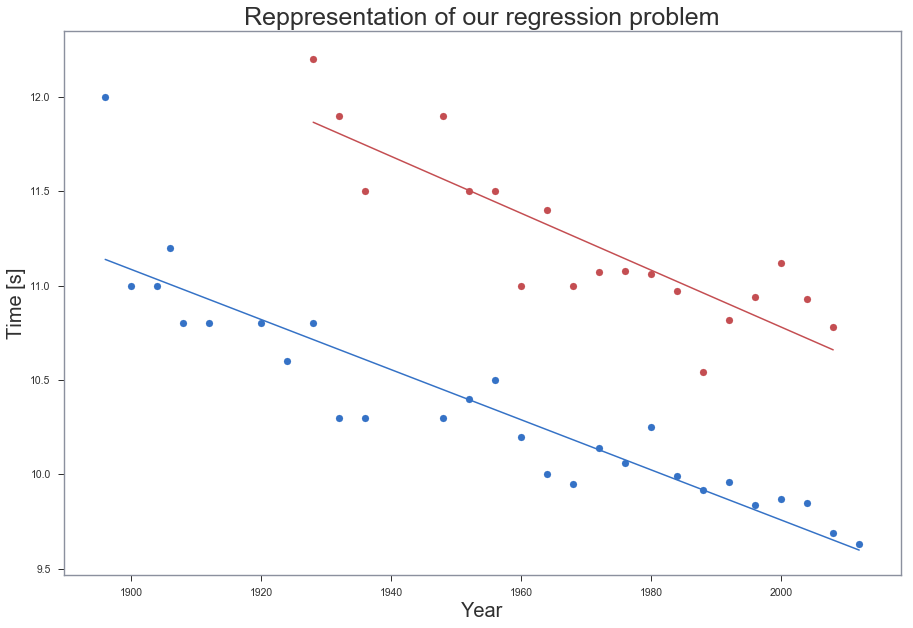

In [70]:
fig = plt.figure(figsize=(15,10) )
ax = fig.add_subplot(111)
y_male = [ w_male[1]*x + w_male[0] for x in data_male[0]]
y_female = [ w_female[1]*x + w_female[0] for x in data_female[0]]


plt.plot(data_male[0], y_male, color='b') 
plt.scatter(data_male[0], data_male[1], color='b')

plt.plot(data_female[0], y_female, color='r') 
plt.scatter(data_female[0], data_female[1], color='r')

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Reppresentation of our regression problem', fontsize=25)
plt.show()

Let's find when they will have the same time

In [71]:
w_bar = np.array(w_male) - np.array(w_female)
w_bar = [w_bar[1], w_bar[0]]
print(np.roots(w_bar))

[ 2568.91953835]


According to this model, male and female will have the same winning time in 2569

## Vectorial formulation

From the simple formulation we had above, we can draw some generalization for regression. First of all, let's move to vector/matrix representation.

The first thing to do is to generate the design matrix, defined as
$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$$

In [54]:
def generateDesignMatrix(x, n):
    X = np.matrix([[x_i**k for k in range(n)] for x_i in x])
    return X

It can be proved that the loss previously defined can be written in matrix form as follows:

$$
L = \dfrac{1}{N} (\mathbf{t} - \mathbf{X}\mathbf{w})^T(\mathbf{t} - \mathbf{X}\mathbf{w})
$$

Differentiating with respect to $\mathbf{w}$, we obtain the following result:

$$
\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}
$$

In [55]:
def calculateW(x, y, n):
    X = generateDesignMatrix(x, n)
    t = np.matrix(y).T

    return (X.T*X).I*X.T*t

In [56]:
w_hat = calculateW(data_male[0], data_male[1], 2)
print(w_hat)

[[  3.63091204e+01]
 [ -1.32753238e-02]]


Let's plot these results

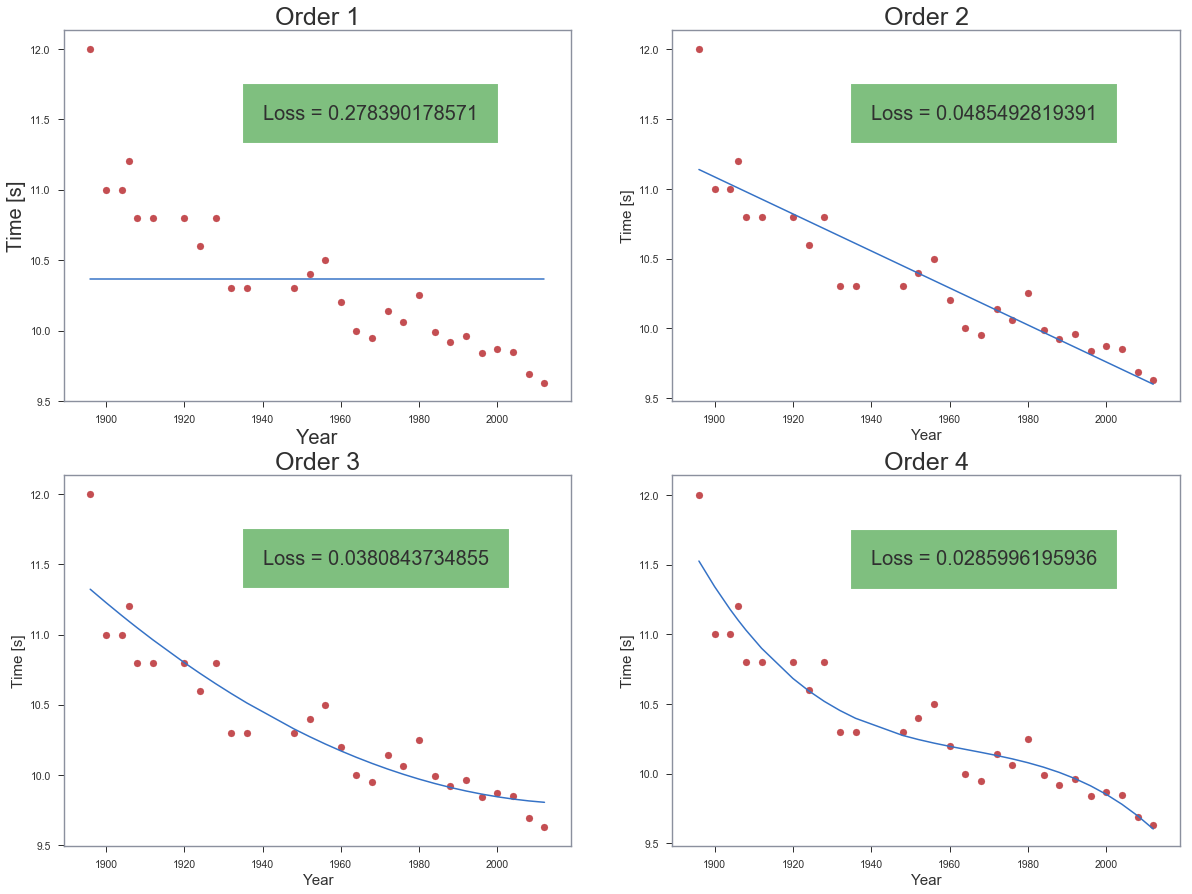

In [73]:
fig = plt.figure(figsize=(20,15) )
ax = fig.add_subplot(221)
w_hat = calculateW(data_male[0], data_male[1], 1)
y = [regression(x, w_hat) for x in data_male[0]]
plt.plot(data_male[0], y) 
plt.scatter(data_male[0], data_male[1], color='r')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
ax.text(1940, 11.5, 'Loss = ' + str(loss(w_hat.T.tolist()[0], data_male[0], \
                                         data_male[1])), fontsize=20, \
        bbox={'facecolor':'green', 'alpha':0.5, 'pad':20})
plt.title('Order 1', fontsize=25)

ax = fig.add_subplot(222)
w_hat = calculateW(data_male[0], data_male[1], 2)
y = [regression(x, w_hat) for x in data_male[0]]
plt.plot(data_male[0], y) 
plt.scatter(data_male[0], data_male[1], color='r')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Time [s]', fontsize=15)
ax.text(1940, 11.5, 'Loss = ' + str(loss(w_hat.T.tolist()[0], data_male[0], \
                                         data_male[1])), fontsize=20, \
        bbox={'facecolor':'green', 'alpha':0.5, 'pad':20})
plt.title('Order 2', fontsize=25)

ax = fig.add_subplot(223)
w_hat = calculateW(data_male[0], data_male[1], 3)
y = [regression(x, w_hat) for x in data_male[0]]
plt.plot(data_male[0], y) 
plt.scatter(data_male[0], data_male[1], color='r')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Time [s]', fontsize=15)
ax.text(1940, 11.5, 'Loss = ' + str(loss(w_hat.T.tolist()[0], data_male[0], \
                                         data_male[1])), fontsize=20, \
        bbox={'facecolor':'green', 'alpha':0.5, 'pad':20})
plt.title('Order 3', fontsize=25)

ax = fig.add_subplot(224)
w_hat = calculateW(data_male[0], data_male[1], 4)
y = [regression(x, w_hat) for x in data_male[0]]
plt.plot(data_male[0], y) 
plt.scatter(data_male[0], data_male[1], color='r')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Time [s]', fontsize=15)
ax.text(1940, 11.5, 'Loss = ' + str(loss(w_hat.T.tolist()[0], data_male[0], \
                                         data_male[1])), fontsize=20, \
        bbox={'facecolor':'green', 'alpha':0.5, 'pad':20})
plt.title('Order 4', fontsize=25)
plt.show()

Increasing the complexity of the model, loss always decreases. Not useful for model selection

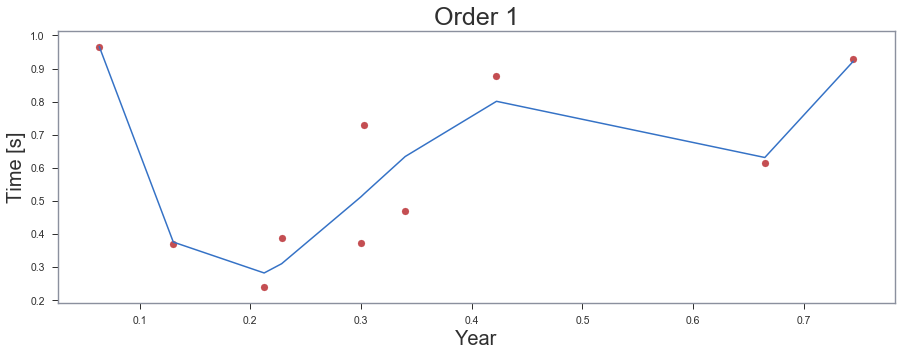

In [64]:
newData = np.random.rand(10, 1).T.tolist()[0]
newData.sort()
newT = np.random.rand(10, 1).T.tolist()[0]

w_hat = calculateW(n=5, x=newData, y=newT)


fig = plt.figure()
ax = fig.add_subplot(111)

y = [regression(x, w_hat) for x in newData]
plt.plot(newData, y) 
plt.scatter(newData, newT, color='r')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Order 1', fontsize=25)
plt.show()

In [59]:
print(data_male.T[[0, 1]].T)

[[ 1896.  1900.]
 [   12.    11.]]


In [60]:
def LOO(dataset, complexity=2):
    errors = []
    list_indexes = list(range(0, len(dataset.T)))

    for i in list(range(len(list_indexes))):
        index_out = list_indexes.pop(0)
        data_LOO = dataset.T[list_indexes].T
        list_indexes.append(index_out)
        x_train = data_LOO[0] - data_LOO[0][0]
        #pprint(x_train)
        t_train = data_LOO[1]
        x_test = dataset.T[index_out][0] - data_LOO[0][0]
        t_test = dataset.T[index_out][1]

        model = calculateW(x_train, t_train, n=complexity)

        t_model = regression(x_test, model)
        #errors.append((x_test, ((t_test - t_model) ** 2)[0]))
        errors.append(((t_test - t_model) ** 2)[0])
    return np.array(errors)

In [61]:
pprint(LOO(data_female, complexity=2).mean())

0.06169528905210258


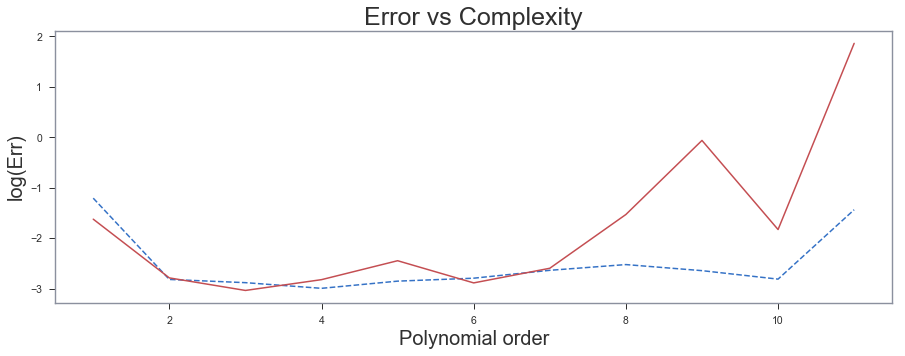

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = range(1,12)
y_male = [math.log(LOO(data_male, complexity=int(i)).mean()) for i in x]
y_female = [math.log(LOO(data_female, complexity=int(i)).mean()) for i in x]


plt.plot(x, y_male, 'b--',)
plt.plot(x, y_female, color='r',)
ax.set_xlabel('Polynomial order', fontsize=20)
ax.set_ylabel(u'log(Err)', fontsize=20)
plt.title('Error vs Complexity', fontsize=25)
plt.show()